In [1]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import os
import warnings

# Basics of Python data handling and visualization
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta
from shapely.geometry import Polygon

# Imports from eo-learn and sentinelhub-py
from eolearn.core import (
    EOExecutor,
    EOPatch,
    EOTask,
    EOWorkflow,
    FeatureType,
    LinearWorkflow,
    LoadTask,
    MergeFeatureTask,
    OverwritePermission,
    SaveTask
)
from eolearn.io import (
    SentinelHubInputTask
)
from sentinelhub import (
    DataCollection,
    SHConfig,
    UtmZoneSplitter
)

## Define areas of interest

### Load ROI

In [2]:
test_area = gpd.read_file('../data/gillam_mb_canada.geojson')
test_area = test_area.to_crs('EPSG:32615')
test_area = test_area.buffer(500)

In [ ]:
test_area = gpd.read_file('../data/mystery_lake_mb_canada.geojson')
test_area = test_area.to_crs('EPSG:32614')
test_area = test_area.buffer(500)

In [ ]:
test_area = gpd.read_file('../data/yellowknife_nt_canada.geojson')
test_area = test_area.to_crs('EPSG:32611')
test_area = test_area.scale(3, 1)
test_area = test_area.buffer(500)

In [ ]:
test_area = gpd.read_file('../data/north_slave_region_nt_canada.geojson')
test_area = test_area.to_crs('EPSG:32611')
test_area = test_area.buffer(500)

In [ ]:
test_area = gpd.read_file('/home/andresf/data/permafrost-imagery/northwest_territories_highway_3/highways_streets_trunk.shp')
test_area = test_area.to_crs('EPSG:32611')
test_area = test_area.buffer(2000)

### Display AOI

<AxesSubplot:>

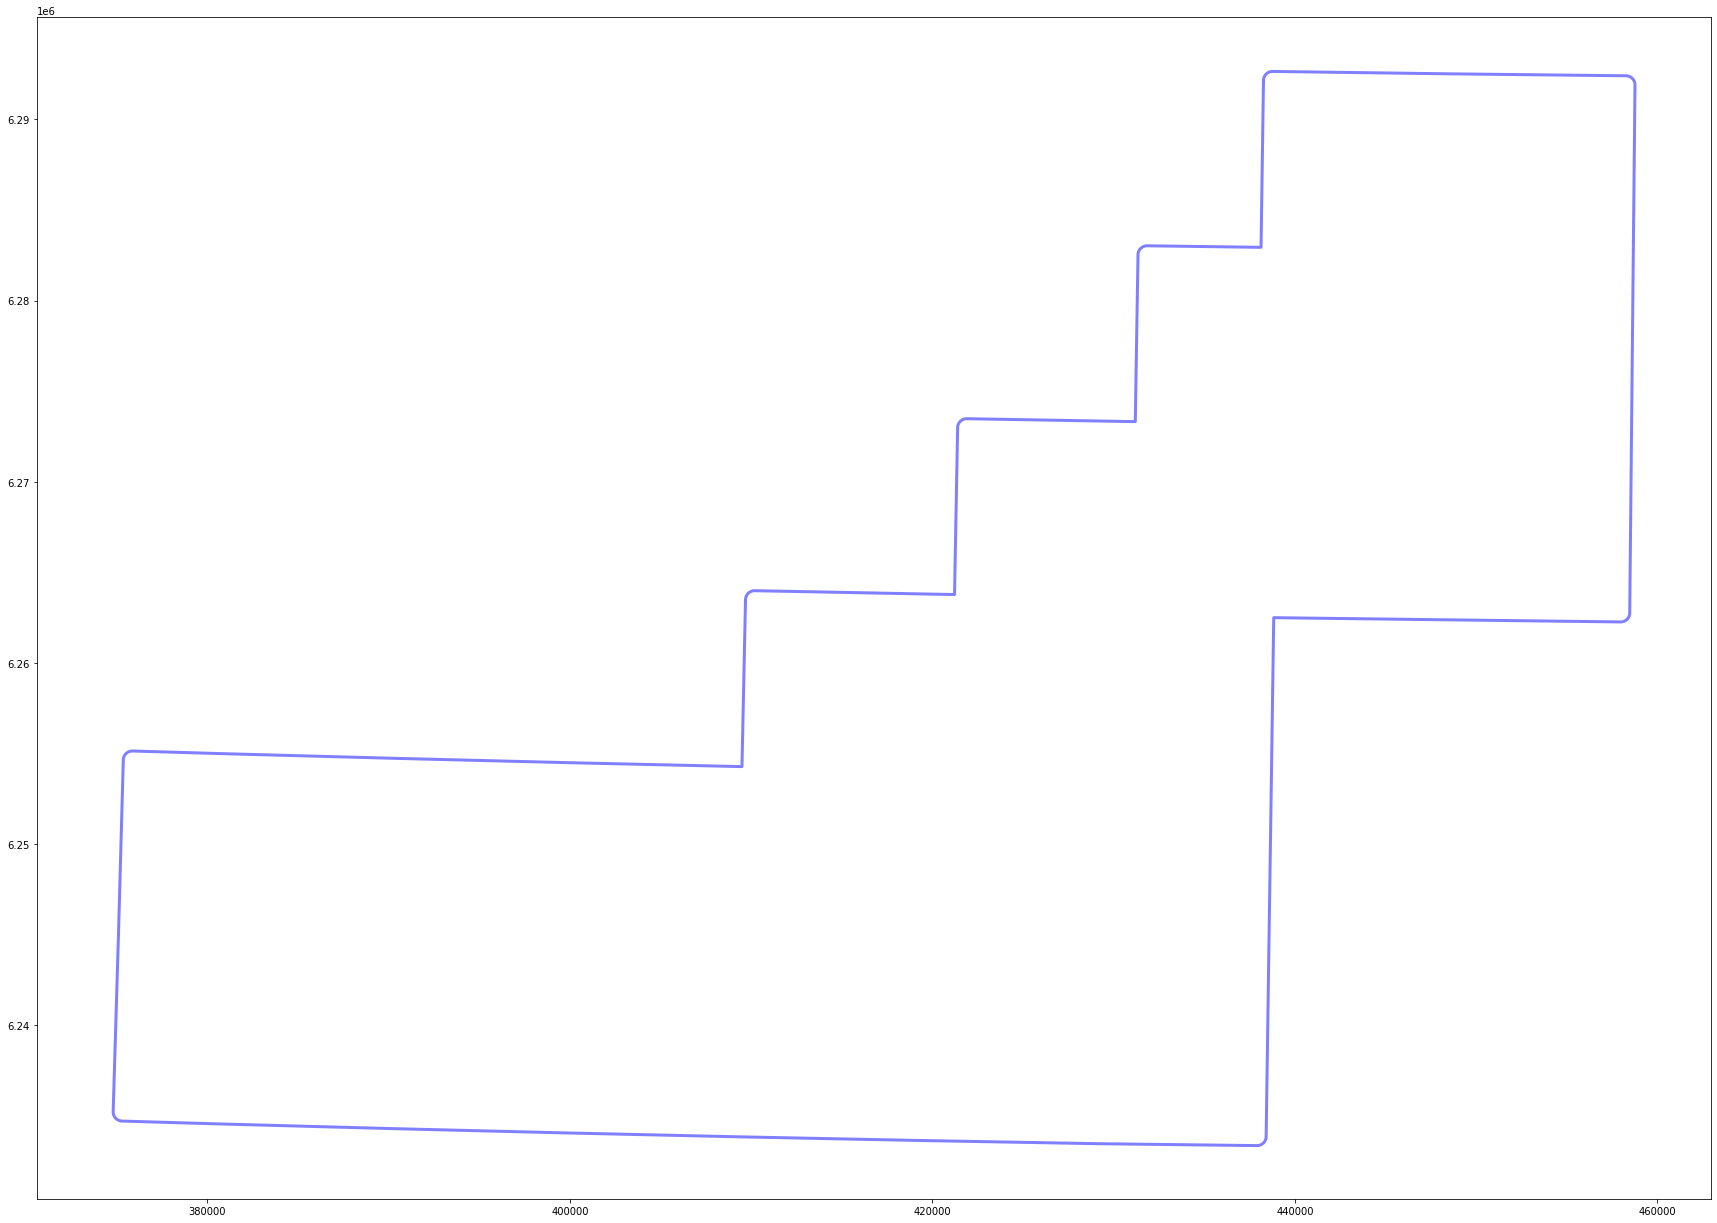

In [3]:
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(figsize=(30, 30))

test_area.plot(ax=ax,
               facecolor='w',
               edgecolor='b',
               alpha=0.5,
               linewidth=3.0)

### Split ROI

In [4]:
bbox_splitter = UtmZoneSplitter(shape_list=[g for g in test_area.geometry],
                                crs=test_area.crs,
                                bbox_size=2500)

bbox_list = bbox_splitter.get_bbox_list()
info_list = bbox_splitter.get_info_list()

### Visualize bounding boxes

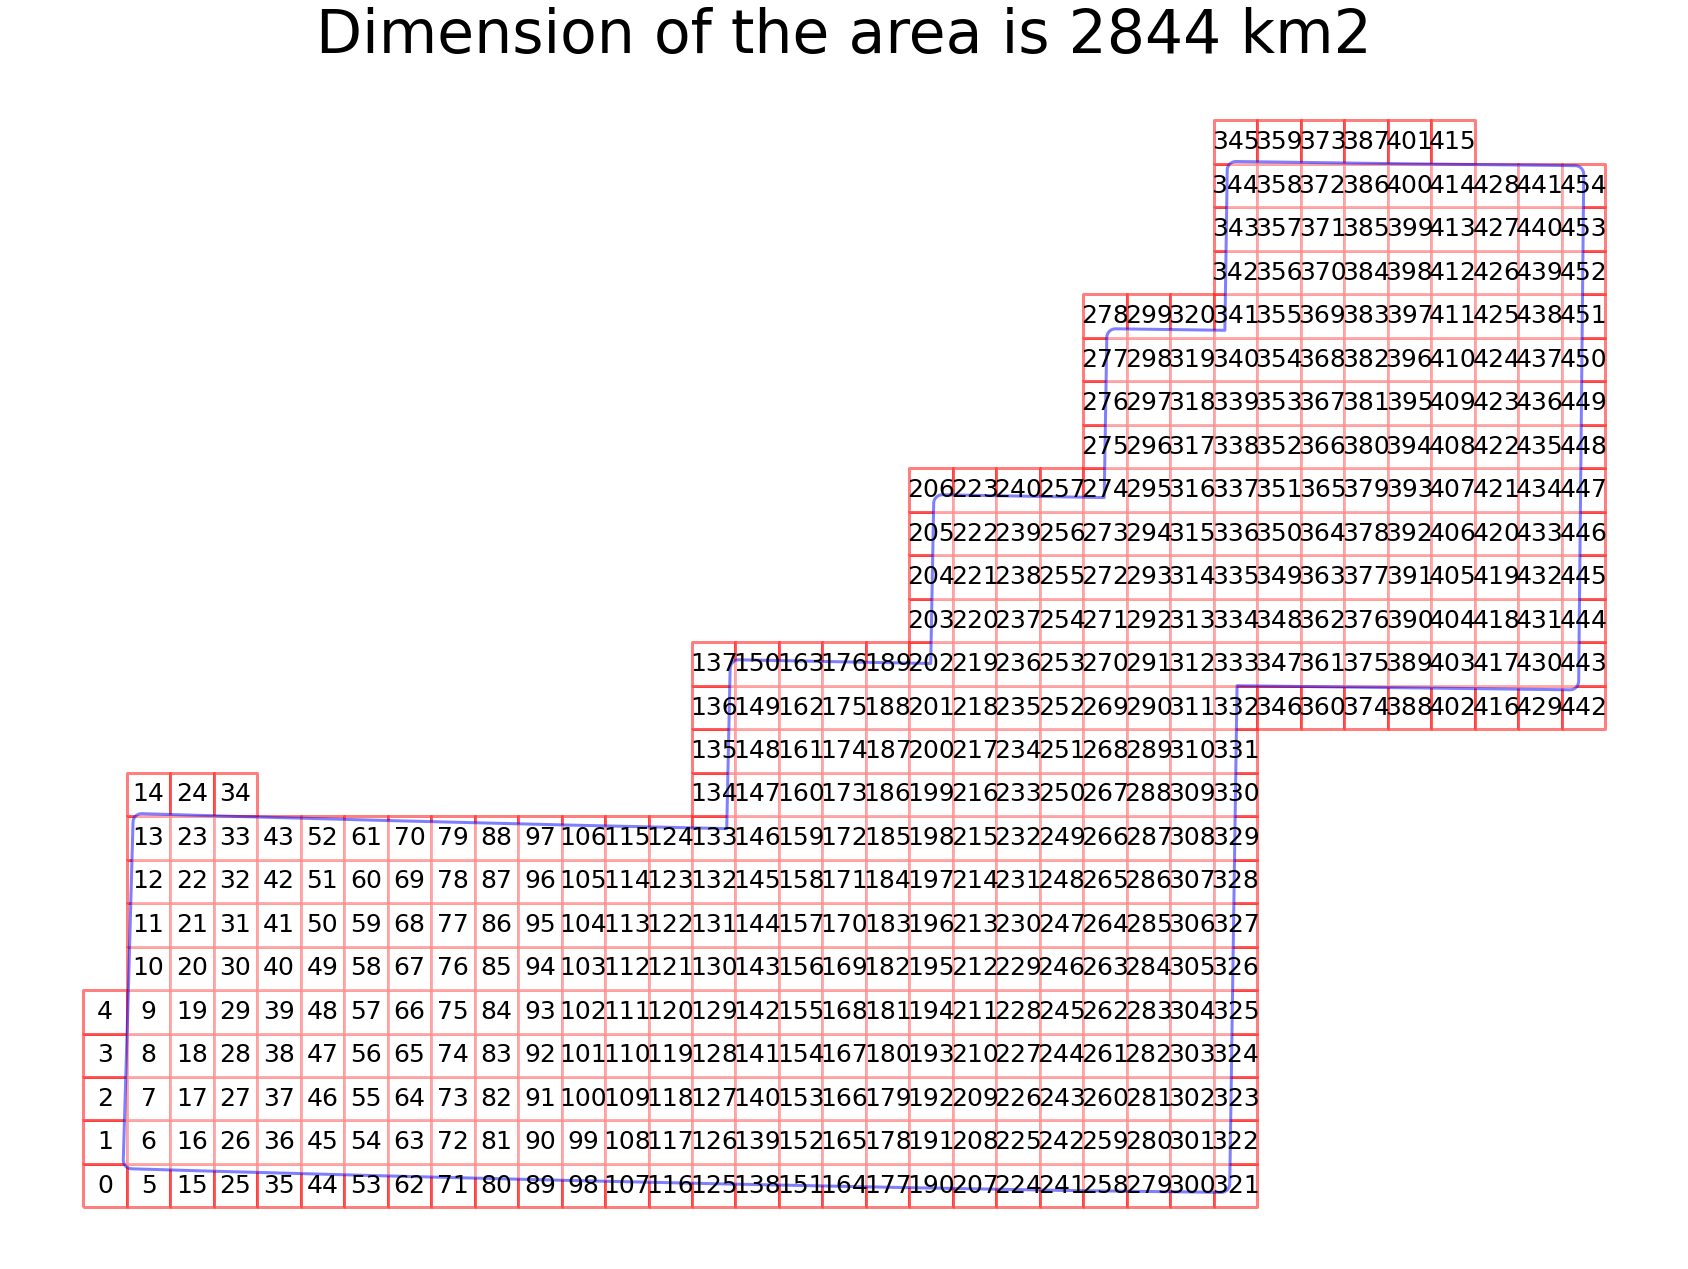

In [5]:
def display_bboxes(test_area, bboxes, infos):

    # Prepare bounding boxes info and geometry
    idxs = [info['index'] for info in infos]
    idxs_x = [info['index_x'] for info in infos]
    idxs_y = [info['index_y'] for info in infos]
    geometry = [Polygon(bbox.get_polygon()) for bbox in bboxes]

    # Compose bounding boxes geodataframe
    bbox_gdf = gpd.GeoDataFrame({'index': idxs,
                                 'index_x': idxs_x,
                                 'index_y': idxs_y},
                                crs=test_area.crs,
                                geometry=geometry)

    # Save bounding boxes to file
    # bbox_gdf.to_file(f'{data_dir}/{location}/grid.shp')

    # Display bounding boxes over test area
    fig, ax = plt.subplots(figsize=(30, 30))

    # Plot bounding boxes
    bbox_gdf.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5, linewidth=3.0)
    # Plot area of interest
    test_area.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5, linewidth=3.0)

    # Display bounding boxes labels
    for bbox, info in zip(bboxes, infos):
        geo = bbox.geometry
        ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center', fontsize=25)

    plt.axis('off')
    plt.title(f'Dimension of the area is {(len(bbox_list) * 2.5 * 2.5):.0f} km2', fontdict={'fontsize': 60})

display_bboxes(test_area, bbox_list, info_list)

## Fill EOPatches with data

In [6]:
config = SHConfig()

# OAuth Client ID
config.sh_client_id = ''

# OAuth Client Secret
config.sh_client_secret = ''

# Account ID
config.instance_id = ''
config.aws_access_key_id = ''
config.aws_secret_access_key = ''

In [7]:
location = 'gillam_mb_canada'
# location = 'mystery_lake_mb_canada'
# location = 'yellowknife_nt_canada'

home_dir = os.environ['HOME']
data_dir = f'{home_dir}/data/northern-cities'

In [8]:
# Canonical names of Sentinel-2 bands to retrieve
band_names = ['B02', 'B03', 'B04', 'B08']
# band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']

# Time interval for the Sentinel-Hub request
time_interval = ['2020-01-01', '2020-12-31']

### Define tasks

In [9]:
get_s2_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands=band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5,
    cache_folder=f'{home_dir}/eo_learn_cache/',
    config=config
)

save_s2 = SaveTask(f'{data_dir}/{location}/eopatches_raw/',
                   config=config,
                   overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Define workflow

In [10]:
workflow = EOWorkflow([
    (get_s2_data, [], 'Get S2 data'),
    (save_s2, [get_s2_data], 'Save S2 data')
])

### Visualize workflow

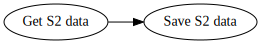

In [11]:
workflow.dependency_graph()

### Prepare execution arguments

In [13]:
execution_args = []

for idx, bbox in enumerate(bbox_list):
    print(f'eopatch-{idx:04d}')
    execution_args.append({
        get_s2_data: {'bbox': bbox, 'time_interval': time_interval},
        save_s2: {'eopatch_folder': f'eopatch-{idx:04d}'}
    })

len(execution_args)

eopatch-0000
eopatch-0001
eopatch-0002
eopatch-0003
eopatch-0004
eopatch-0005
eopatch-0006
eopatch-0007
eopatch-0008
eopatch-0009
eopatch-0010
eopatch-0011
eopatch-0012
eopatch-0013
eopatch-0014
eopatch-0015
eopatch-0016
eopatch-0017
eopatch-0018
eopatch-0019
eopatch-0020
eopatch-0021
eopatch-0022
eopatch-0023
eopatch-0024
eopatch-0025
eopatch-0026
eopatch-0027
eopatch-0028
eopatch-0029
eopatch-0030
eopatch-0031
eopatch-0032
eopatch-0033
eopatch-0034
eopatch-0035
eopatch-0036
eopatch-0037
eopatch-0038
eopatch-0039
eopatch-0040
eopatch-0041
eopatch-0042
eopatch-0043
eopatch-0044
eopatch-0045
eopatch-0046
eopatch-0047
eopatch-0048
eopatch-0049
eopatch-0050
eopatch-0051
eopatch-0052
eopatch-0053
eopatch-0054
eopatch-0055
eopatch-0056
eopatch-0057
eopatch-0058
eopatch-0059
eopatch-0060
eopatch-0061
eopatch-0062
eopatch-0063
eopatch-0064
eopatch-0065
eopatch-0066
eopatch-0067
eopatch-0068
eopatch-0069
eopatch-0070
eopatch-0071
eopatch-0072
eopatch-0073
eopatch-0074
eopatch-0075
eopatch-0076

455

### Execute the workflow

In [ ]:
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=1, multiprocess=True)

executor.make_report()

failed_ids = executor.get_failed_executions()

if failed_ids:
    raise RuntimeError(f'Execution failed EOPatches with IDs:\n{failed_ids}\n'
                       f'For more info check report at {executor.get_report_filename()}')

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(43, 250, 250, 4), dtype=float32)
    CLP: numpy.ndarray(shape=(43, 250, 250, 1), dtype=uint8)
    FEATURES: numpy.ndarray(shape=(43, 250, 250, 4), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(43, 250, 250, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(43, 250, 250, 1), dtype=bool)
    IS_VALID: numpy.ndarray(shape=(43, 250, 250, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    size_x: 250
    size_y: 250
    time_difference: datetime.timedelta(seconds=7200)
    time_interval: (datetime.datetime(2020, 1, 1, 0, 0), datetime.datetime(2020, 12, 31, 23, 59, 59))
  }
  bbox: BBox(((372500.0, 6232500.0), (375000.0, 6235000.0)), crs=CRS('32615'))
  timestamp: [datetime.datetime(2020, 1, 11, 17, 38, 7), ..., datetime.datetime(2020, 12, 26, 17, 38, 13)], length=43
)


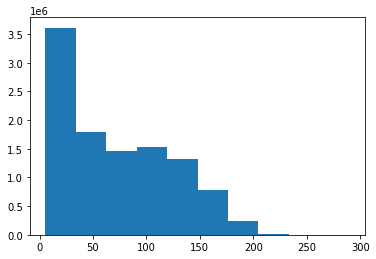

In [14]:
eopatch = EOPatch.load(f'{data_dir}/{location}/eopatches_clean/eopatch-0000/')

print(eopatch)

plt.hist(eopatch.data['BANDS'].flatten() * 255)

del eopatch